In [1]:
# Useful starting lines
%matplotlib inline
%load_ext autoreload
%autoreload 2
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from gensim import models
from collections import defaultdict
import pickle
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Import all functions from the Labs and helpers
import utils
import text_cleaner
import features_analysis

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

C:\Users\Leonovo\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data loading

In [2]:
DATASET_PATH = '../twitter-datasets/'
SAMPLE = False

In [3]:
if SAMPLE:
    train_pos_data = utils.load_training_data(DATASET_PATH + "train_pos.txt")
    train_neg_data = utils.load_training_data(DATASET_PATH + "train_neg.txt")
else:
    train_pos_data = utils.load_training_data(DATASET_PATH +
                                              "train_pos_full.txt")
    train_neg_data = utils.load_training_data(DATASET_PATH +
                                              "train_neg_full.txt")

train_target = np.concatenate(
    (np.ones(len(train_pos_data)), (-np.ones(len(train_neg_data))))
)
train_data = np.concatenate((train_pos_data, train_neg_data))
test_data = utils.load_test_data("../twitter-datasets/test_data.txt")

Successfully loaded data from ../twitter-datasets/train_pos_full.txt
Successfully loaded data from ../twitter-datasets/train_neg_full.txt
Successfully loaded data from ../twitter-datasets/test_data.txt


In [4]:
train_data.shape

(2500000,)

# Data preprocessing

## Some plots

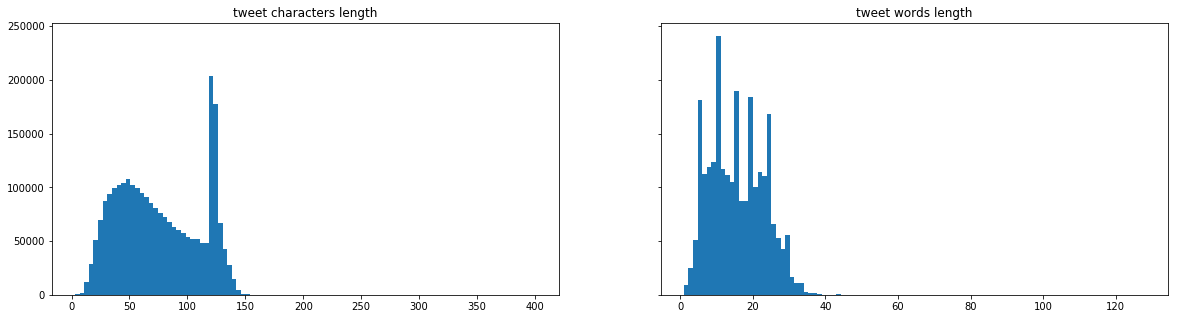

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist([len(twit) for twit in train_data], bins=100)
ax1.set_title('tweet characters length')
ax2.hist([len(twit.split()) for twit in train_data], bins=100)
ax2.set_title('tweet words length')
f.set_figheight(5)
f.set_figwidth(20)
plt.show()

## custom data cleaning

In [5]:
cleaner = text_cleaner.text_cleaner()

In [6]:
# save the cleaned data, doesn't clean if file is present
try:
    train_data_cleaned = pickle.load( open( "train_data_cleaned.p", "rb" ) )
    test_data_cleaned = pickle.load( open( "test_data_cleaned.p", "rb" ) )
except:
    train_data_cleaned = cleaner.apply_to_all(train_data)
    test_data_cleaned = cleaner.apply_to_all(test_data)
    pickle.dump( train_data_cleaned, open( "train_data_cleaned.p", "wb" ) )
    pickle.dump( test_data_cleaned, open( "test_data_cleaned.p", "wb" ) )

## sentiment analysis score with Vador

In [29]:
try:
    train_sentiments = pickle.load( open( "train_sentiments.p", "rb" ) )
    test_sentiments = pickle.load( open( "test_sentiments.p", "rb" ) )
except:
    analyzer = SentimentIntensityAnalyzer()

    train_sentiments = []
    for tweet in train_data_cleaned:
        train_sentiments.append(list(analyzer.polarity_scores(tweet).values()))

    test_sentiments = []
    for tweet in test_data_cleaned:
        test_sentiments.append(list(analyzer.polarity_scores(tweet).values()))
        
    pickle.dump( train_sentiments, open( "train_sentiments.p", "wb" ) )
    pickle.dump( test_sentiments, open( "test_sentiments.p", "wb" ) )

In [53]:
train_sentiments[0]

[0.0, 0.795, 0.205, 0.6597]

In [56]:
np.std(np.array(train_sentiments[:1250000]), axis=0)

array([ 0.08823618,  0.19818146,  0.19086498,  0.38487862])

In [57]:
np.std(np.array(train_sentiments[1250000:]), axis=0)

array([ 0.13453464,  0.17425589,  0.1304291 ,  0.39448042])

# Text representation

## FastText

In [5]:
import fasttext
model = fasttext.load_model('../files/wiki-news-300d-1M.vec')
print(model['machine']) # get the vector of the word 'machine'

Exception: fastText: Cannot load ../files/wiki-news-300d-1M.vec due to C++ extension failed to allocate the memory

## word2vec

In [12]:
#bigram_transformer = models.Phrases(train_data_cleaned_tokens)
#bigram_model = models.Word2Vec(bigram_transformer[train_data_cleaned_tokens], size=100, min_count=5, workers=4)

C:\Users\Leonovo\Anaconda3\lib\site-packages\gensim\models\phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [87]:
train_data_cleaned_tokens = [nltk.word_tokenize(x) for x in train_data_cleaned]
test_data_cleaned_tokens = [nltk.word_tokenize(x) for x in test_data_cleaned]

In [88]:
try:
    # load model
    model = models.Word2Vec.load('word2vecModel') 
except:
    model = models.Word2Vec(train_data_cleaned_tokens, size=300, window=5, min_count=5, workers=4)
    # save model
    model.save('word2vecModel')
    
word_vector = model.wv

In [102]:
word_vector.similar_by_word('sad',5)

[('upset', 0.7690680027008057),
 ('depress', 0.7277838587760925),
 ('sadd', 0.6771323680877686),
 ('saddd', 0.6741654872894287),
 ('heartbreak', 0.6381857991218567)]

In [104]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = 100

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(lambda: max_idf, 
                                       [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
            np.mean(
                [self.word2vec[w] * self.word2weight[w] for w in words if w in self.word2vec]
                or [np.zeros(self.dim)],
                axis=0) for words in X
        ])

In [105]:
# save the cleaned data, doesn't clean if file is present
try:
    train_data_cleaned_vect = pickle.load( open( "train_data_cleaned_vect.p", "rb" ) )
    test_data_cleaned_vect = pickle.load( open( "test_data_cleaned_vect.p", "rb" ) )
except:
    w2v = dict(zip(word_vector.index2word, word_vector.syn0))
    emb_vect = TfidfEmbeddingVectorizer(w2v).fit(train_data_cleaned, train_target)
    train_data_cleaned_vect = emb_vect.transform(train_data_cleaned)
    test_data_cleaned_vect = emb_vect.transform(test_data_cleaned)
    pickle.dump( train_data_cleaned_vect, open( "train_data_cleaned_vect.p", "wb" ) )
    pickle.dump( test_data_cleaned_vect, open( "test_data_cleaned_vect.p", "wb" ) )

### PCA kinda

In [126]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
svd.fit(train_data_tdidf)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=42, tol=0.0)

In [127]:
train_data_cleaned_vect_reduced = svd.fit_transform(train_data_tdidf)

In [128]:
a = [0 if v is None else v for v in train_data_cleaned_vect_reduced]

In [129]:
a = np.array(a)
a.shape

(200000, 2)

[]

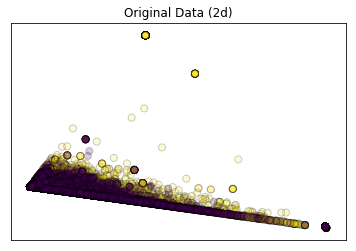

In [130]:
ax = plt.subplot()
ax.scatter(
    a[:, 0],
    a[:, 1],
    c=train_target,
    s=50,
    edgecolor='k',
    alpha=0.2)
ax.set_title("Original Data (2d)")
ax.set_xticks(())
ax.set_yticks(())

## tf idf

In [7]:
max_occ_per = 0.75
min_occ_per = 5

tfidf_vect = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', min_df=min_occ_per , max_df=max_occ_per)

In [8]:
train_data_tdidf = tfidf_vect.fit_transform(train_data_cleaned)
test_data_tdidf = tfidf_vect.transform(test_data_cleaned)
feat_names = tfidf_vect.get_feature_names()

In [9]:
len(feat_names)

700309

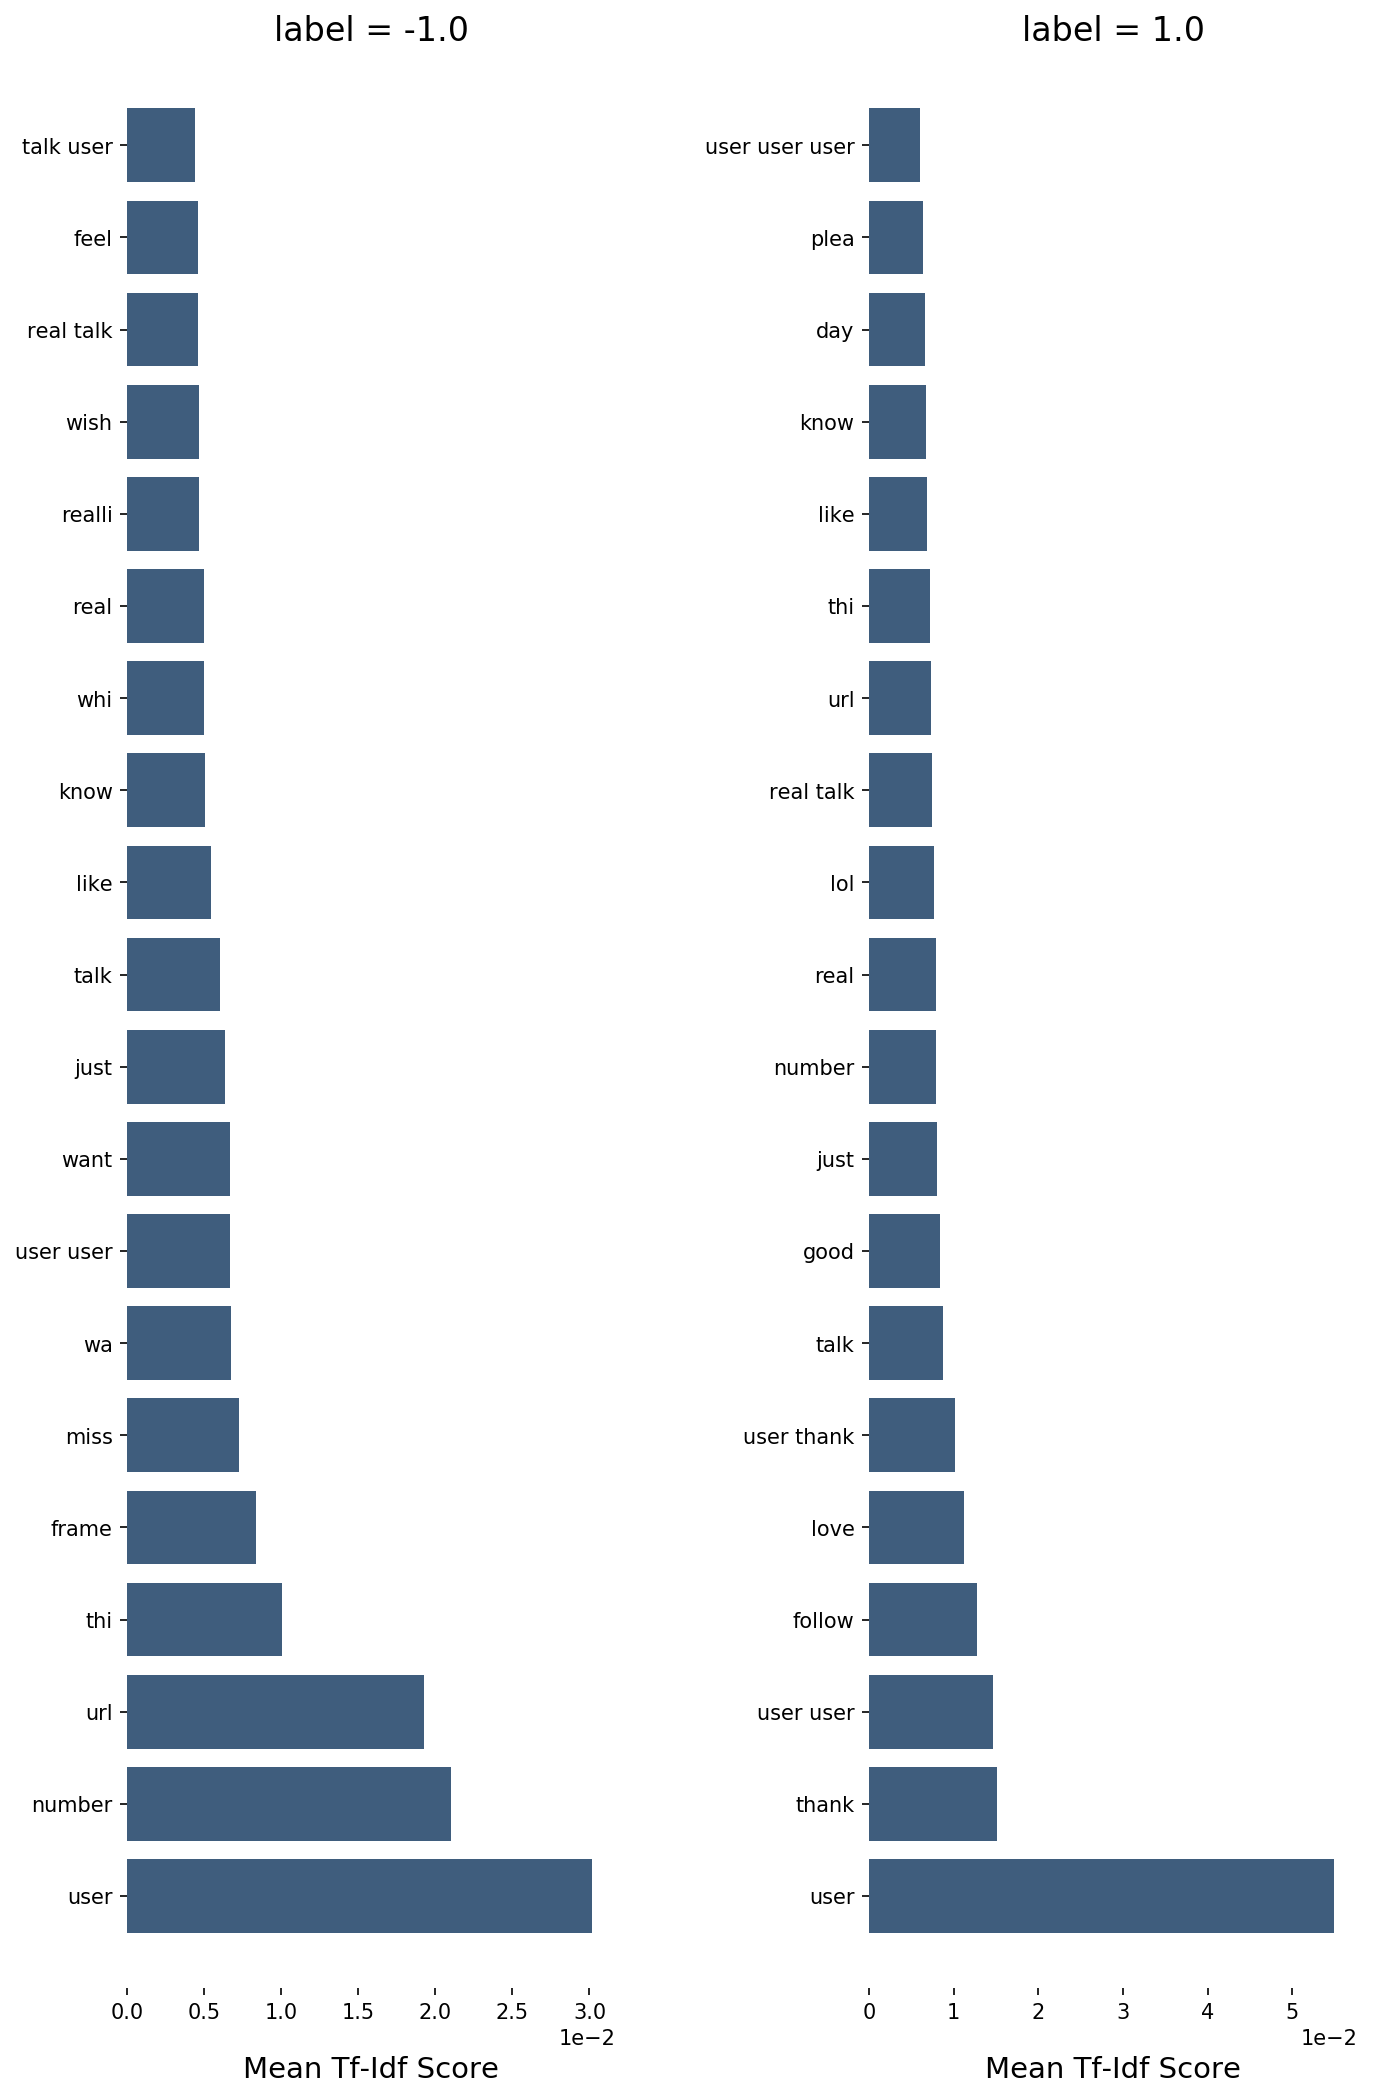

In [10]:
dfs = features_analysis.top_feats_by_class(train_data_tdidf, train_target, feat_names, top_n=20)
features_analysis.plot_tfidf_classfeats_h(dfs)

# Machine learning

## Model selection

In [11]:
classifiers = [
    MultinomialNB(),
    LogisticRegression(max_iter=200, tol = 1e-3
                       #, solver='sag'
                      ),
    SGDClassifier(alpha=1e-5, random_state=42),
    RandomForestClassifier(max_depth=100, n_estimators=100),
]

classifiers_names = [
    'naive Bayes',
    'logistic regression',
    'Linear classifiers (SVM, logistic regression) with SGD',
    'Random Forest'
]

def test_classifiers(classifiers, names, data, target, cv=3):
    for i, classifier in enumerate(classifiers):
        scores = cross_val_score(classifier, data, target, cv=cv, n_jobs=-1, verbose=10)
        print(names[i])
        print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

### with TFIDF

In [ ]:
# trigrams
test_classifiers(classifiers, classifiers_names, train_data_tdidf, train_target)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s finished


naive Bayes
Accuracy: 0.795 (+/- 0.002)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


logistic regression
Accuracy: 0.822 (+/- 0.002)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.0s finished


Linear classifiers (SVM, logistic regression) with SGD
Accuracy: 0.809 (+/- 0.002)


In [23]:
# bigrams
test_classifiers(classifiers, classifiers_names, train_data_tdidf, train_target)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.6s remaining:   30.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.6s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished


naive Bayes
Accuracy: 0.793 (+/- 0.003)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.9min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  6.3min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.0min finished


logistic regression
Accuracy: 0.823 (+/- 0.003)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   29.3s remaining:   44.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   29.3s remaining:   19.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.4s finished


Linear classifiers (SVM, logistic regression) with SGD
Accuracy: 0.809 (+/- 0.002)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.8min remaining: 19.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.8min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.6min finished


Random Forest
Accuracy: 0.570 (+/- 0.075)


### with word2vec

In [66]:
classifiers_names[1:3]

['logistic regression',
 'Linear classifiers (SVM, logistic regression) with SGD']

In [67]:
# cannot use naive bayes with negative values
test_classifiers(classifiers[1:3], classifiers_names[1:3],
                 train_data_cleaned_vect,
                 train_target)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.6min finished


logistic regression
Accuracy: 0.692 (+/- 0.003)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.8s finished


Linear classifiers (SVM, logistic regression) with SGD
Accuracy: 0.657 (+/- 0.015)


## Model tuning

### tfidf

#### sdgClassifier

In [10]:
text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.75)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-6,
        tol = 1e-3,
        max_iter = 500,
        random_state=42, )),
])

}

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__ngram_range': ((1, 2)),
    #'loss' : ('hinge', 'log','squared_loss', 'huber', 'epsilon_insensitive'),
    'clf__alpha': np.logspace(-6, -9, 3),
    #'penalty': ('l2', 'elasticnet'),
    #'n_iter': (200),
    'clf__tol' : np.logspace(-3, -5, 3) ,
    'clf__max_iter' : (500,1000,2000)
}



gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, verbose=10, cv=3)

In [11]:
gs_clf = gs_clf.fit(train_data_cleaned, train_target)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 13.7min finished


In [12]:
gs_clf.best_score_

0.78688000000000002

In [13]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 3.1622776601683792e-06
clf__max_iter: 500
clf__tol: 0.001


#### logistic regression

In [16]:
text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df = 5, max_df=0.75)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter=200, tol = 1e-5)),
])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__ngram_range': ((1, 2)),
    #'loss' : ('hinge', 'log','squared_loss', 'huber', 'epsilon_insensitive'),
    #'penalty': ('l2', 'elasticnet'),
    #'n_iter': (200),
    #'clf__tol' : 1e-4 ,
    'clf__max_iter' : (50,100,200),
    'clf__solver' : ('liblinear', 'sag'),
}


gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, verbose=10, cv=3)

In [17]:
gs_clf = gs_clf.fit(train_data_cleaned, train_target)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 35.9min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed: 36.3min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 40.6min finished


In [21]:
print(gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.8199604
clf__max_iter: 50
clf__solver: 'sag'


### w2v

In [72]:
clf = SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-6,
        tol = 1e-3,
        max_iter = 200, )


parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__ngram_range': ((1, 2)),
    #'loss' : ('hinge', 'log','squared_loss', 'huber', 'epsilon_insensitive'),
    'alpha': np.logspace(-6, -9, 3),
    #'penalty': ('l2', 'elasticnet'),
    #'n_iter': (200),
    'tol' : np.logspace(-3, -5, 3) ,
    'max_iter' : (50,100,200)
}

gs_clf = GridSearchCV(clf, parameters, n_jobs=-1, verbose=10, cv=3)

In [73]:
gs_clf = gs_clf.fit(train_data_cleaned_vect, train_target)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 61.0min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 85.7min finished


In [74]:
print(gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.6904096
alpha: 9.9999999999999995e-07
max_iter: 200
tol: 0.0001


### diff full et pas full

In [86]:
clf = SGDClassifier(alpha=9.99e-7, max_iter=200, tol=0.0001)
full_train = preprocessing.normalize(
    np.concatenate((train_sentiments, train_data_cleaned_vect), axis=1))

cross_val_score(
    clf, full_train, train_target, cv=5, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.5min remaining:  9.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  6.7min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.0min finished


array([ 0.73514 ,  0.737554,  0.733654,  0.736346,  0.734122])

### same avec vect 300

In [107]:
clf = SGDClassifier(alpha=9.99e-7, max_iter=200, tol=0.0001)
full_train = preprocessing.normalize(
    np.concatenate((train_sentiments, train_data_cleaned_vect), axis=1))

cross_val_score(
    clf, full_train, train_target, cv=3, n_jobs=-1, verbose=10)

MemoryError: 

In [106]:
train_data_cleaned_vect.shape

(2500000, 300)

## Validation

In [42]:
clf = LogisticRegression(solver='sag', max_iter=200, tol = 1e-5, n_jobs=-1)
cross_val_score(clf, train_data_tdidf, train_target, cv=5, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


array([ 0.82244 ,  0.824224,  0.819754,  0.823954,  0.822824])

In [31]:
from scipy.sparse import hstack
from sklearn.preprocessing import normalize

full_train = preprocessing.normalize(
    hstack([
        train_sentiments,
        train_data_tdidf
    ]))



In [43]:
cross_val_score(clf, full_train, train_target, cv=5, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


array([ 0.821468,  0.823288,  0.818774,  0.823088,  0.82168 ])

In [45]:
np.mean([ 0.821468,  0.823288,  0.818774,  0.823088,  0.82168 ])

0.82165959999999993

# Generate submission

In [84]:
#clf = SGDClassifier(alpha=1e-6, max_iter=200, tol=1e-3, n_jobs=-1)
clf = SGDClassifier(alpha=9.99e-7, max_iter=200, tol=0.0001, n_jobs=-1)
clf.fit(train_data_tdidf, train_target)
pred = clf.predict(test_data_tdidf)

In [25]:
clf = LogisticRegression(solver='sag', max_iter=200, tol = 1e-5, n_jobs=-1)
clf.fit(train_data_tdidf, train_target)
pred = clf.predict(test_data_tdidf)

In [111]:
full_train = (
    np.concatenate((train_sentiments, train_data_cleaned_vect), axis=1))

full_test = (
    np.concatenate((test_sentiments, test_data_cleaned_vect), axis=1))

clf = SGDClassifier(alpha=9.99e-7, max_iter=200, tol=0.0001, n_jobs=-1)
clf.fit(full_train, train_target)

pred = clf.predict(full_test)

In [112]:
full_train.shape

(2500000, 304)

In [113]:
from datetime import datetime
now_string = datetime.now().strftime("%Y%m%d%H%M%S")
utils.create_submission("submission"+now_string, pred.astype(np.int64))

File submission20171207022156.csv succesfully created with 10000 entries
